Electron Density for some HOCl molecules

# From Ryan

https://gaussian.com/cubegen/

- This would be a good place to start for the cubegen command:
```cubegen 1 density=MP2 cl_hocl_tz.fchk cl_hocl_tz.cube```
- where 1 can be replaced with 8  or however many processors you have access to, but there aren't that many points so it shouldn't take long regardless.
- I can also send you the .py file we were looking at earlier if you think that would be helpful. I don't recommend trying to mold it for your use, but it may be a good starting point for you
- If I had a lot of cubegens to run, I would put them in a bash script .sh file which may be helpful as well.

Here's that file I was showing earlier that is crap but has most of the code infrastructure already there. Instead of ctrl+c and ctrl+v-ing it, make sure you understand what's happening lol.

In [ ]:
# %load extractDensity.py

# From Anne:

I think I have put all the files you need in the /gscratch/ilahie/mccoygrp/hocl/eq_jobs directory on MOX.  Let me know if it looks like I missed anything

# Me

- I found the directory and used cubegen with the options specified by Ryan above to make ```br_hocl_tz.cube```

General Plan:
- Make a class that reads in a cube file and gives functionality
- 

In [1]:
import sys
sys.path.append('../CGH_Toolbox/')
import density_cube as dc
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
import numpy as np
import nglview as nv
import MDAnalysis as mda
import pyvibdmc as pv
import utilities as uts

In [6]:
c = dc.cube(filename='br_hocl_tz.cube')

DXDYDZO 0.2721861170212758 0.27301032876712306 0.27301032876712306 0.02028729413998761
hello


In [3]:
c.cdsX[0]

-12.5833

In [23]:
c.atmAr

array([[ 2.629767e+00,  1.881155e+00,  3.000000e-06],
       [ 8.553900e-01,  1.139494e+00, -3.800000e-05],
       [ 4.506029e+00, -6.919500e-01,  0.000000e+00],
       [-2.814172e+00, -1.264450e-01,  0.000000e+00]])

In [8]:
density_Zsum = np.zeros(c.density[:,:,0].shape)

In [23]:
c.density[:,:,0].shape

(95, 74)

In [24]:
c.density.shape

(95, 74, 74)

In [4]:
c.atmStr

['O', 'H', 'Cl', 'Br']

In [9]:
for i in range(len(c.density[0,0,:])):
    density_Zsum = density_Zsum + c.density[:,:,i]

In [34]:
c.cdsZ[36]

0.05924383561643687

In [6]:
br_hocl = mda.Universe("./HOCl/br_hocl_tz.xyz")
br_hocl_view = nv.show_mdanalysis(br_hocl)
br_hocl_view

NGLWidget()

In [47]:
fig = plt.figure()
ax = plt.axes()

ax.scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
ax.scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
ax.scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
ax.scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
ax.set_xlim(-12,12)
ax.set_ylim(-10,10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-10.0, 10.0)

In [46]:
%matplotlib widget
fig, ax = plt.subplots()
CS = ax.contourf(c.cdsX, c.cdsY, c.density[:,:,35].T)
ax.scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
ax.scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
ax.scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
ax.scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
fig.colorbar(CS)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
%matplotlib widget
slices = [20,30,40,50]
fig, ax = plt.subplots(2,2)
for i in range(len(2)):
    for j in range(len(2)):
        CS = ax[i,j].contourf(c.cdsX, c.cdsY, c.density[:,:,slices[2*(i+1)+j+1]].T)
        ax[i,j].scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
        ax[i,j].scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
        ax[i,j].scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
        ax[i,j].scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
        #ax.clabel(CS, inline=True, fontsize=10)
        #ax.set_title('Simplest default with labels')
        fig.colorbar(CS)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'Figure' object has no attribute 'scale'

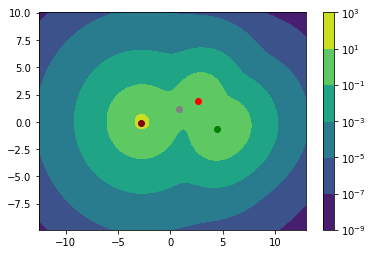

In [29]:
fig, ax = plt.subplots()
CS = ax.contourf(c.cdsX, c.cdsY, density_Zsum.T, locator=ticker.LogLocator())
fig.colorbar(CS)
ax.scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
ax.scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
ax.scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
ax.scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
fig.scale('log')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.show()

In [17]:
c.density.min()

2.39825e-13

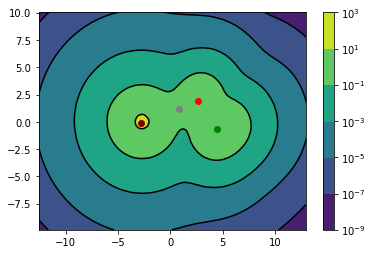

In [10]:
fig, ax = plt.subplots()
CS = ax.contourf(c.cdsX, c.cdsY, density_Zsum.T, norm=LogNorm())
C = ax.contour(c.cdsX, c.cdsY, density_Zsum.T, norm=LogNorm(), colors='k')
fig.colorbar(CS)
ax.scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
ax.scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
ax.scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
ax.scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.show()

In [26]:
c.atmAr[:,0]

array([ 2.629767,  0.85539 ,  4.506029, -2.814172])

chlorine is green

# Cl- HOCl

start with a planar Cl-HOCl molecule and then rotate the Hydrogen out of the plane by 15 and 30 degrees

## Step 1: get planar calculation

In [24]:
clhocl_tz = dc.cube(filename='clhocl-_tz.cube')

DXDYDZO 0.24628345263157847 0.24684258974358997 0.24735558208955233 0.015037548568046894
hello


In [25]:
clhocl_tz.atmStr

['O', 'Cl', 'Cl', 'H']

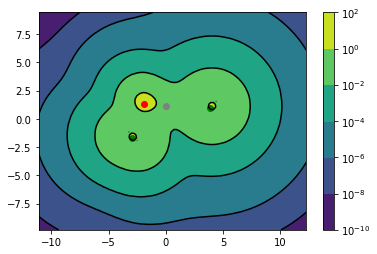

In [36]:
fig, ax = plt.subplots()
CS = ax.contourf(clhocl_tz.cdsX,
                 clhocl_tz.cdsY,
                 (clhocl_tz.density[:,:,33] + clhocl_tz.density[:,:,34]).T,
                 norm=LogNorm())
C = ax.contour(clhocl_tz.cdsX,
               clhocl_tz.cdsY,
               (clhocl_tz.density[:,:,33] + clhocl_tz.density[:,:,34]).T,
               norm=LogNorm(),
               colors='k')
fig.colorbar(CS)
ax.scatter(clhocl_tz.atmAr[:,0][0], clhocl_tz.atmAr[:,1][0], color='red')
ax.scatter(clhocl_tz.atmAr[:,0][1], clhocl_tz.atmAr[:,1][1], color='green')
ax.scatter(clhocl_tz.atmAr[:,0][2], clhocl_tz.atmAr[:,1][2], color='green')
ax.scatter(clhocl_tz.atmAr[:,0][3], clhocl_tz.atmAr[:,1][3], color='gray')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.savefig('temp/clhocl_tz.png')
plt.show()

## Step 2: get 15 degree calculation

In [27]:
clhocl_15 = dc.cube(filename='cl_hocl_15.cube')

DXDYDZO 0.23767521999999985 0.238636394366198 0.23873246376811608 0.013540417741269293
hello


In [28]:
clhocl_15.atmStr

['O', 'Cl', 'Cl', 'H']

In [29]:
clhocl_15.atmAr

array([[ 1.408674e+00,  1.850671e+00, -3.807700e-02],
       [ 3.348949e+00, -6.738080e-01, -7.130000e-04],
       [-3.995636e+00, -2.622060e-01, -8.808000e-03],
       [-2.757190e-01,  1.106860e+00,  4.664760e-01]])

In [33]:
clhocl_tz.atmAr

array([[-1.913951,  1.324799, -0.      ],
       [-2.978241, -1.676258, -0.      ],
       [ 3.878924,  0.986764,  0.      ],
       [-0.      ,  1.123008,  0.      ]])

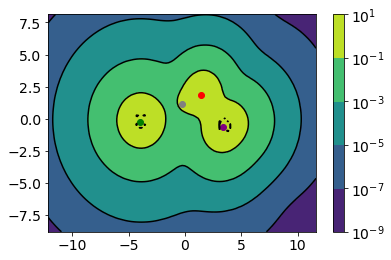

In [38]:
fig, ax = plt.subplots()
CS = ax.contourf(clhocl_15.cdsX,
                 clhocl_15.cdsY,
                 (clhocl_15.density[:,:,33] + clhocl_15.density[:,:,34]).T,
                 norm=LogNorm())
C = ax.contour(clhocl_15.cdsX,
               clhocl_15.cdsY,
               (clhocl_15.density[:,:,33] + clhocl_15.density[:,:,34]).T,
               norm=LogNorm(),
               colors='k')
fig.colorbar(CS)
ax.scatter(clhocl_15.atmAr[:,0][0], clhocl_15.atmAr[:,1][0], color='red')
ax.scatter(clhocl_15.atmAr[:,0][1], clhocl_15.atmAr[:,1][1], color='purple')
ax.scatter(clhocl_15.atmAr[:,0][2], clhocl_15.atmAr[:,1][2], color='green')
ax.scatter(clhocl_15.atmAr[:,0][3], clhocl_15.atmAr[:,1][3], color='gray')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.savefig('temp/clhocl_15.png')
plt.show()

## Oh No! Things have rotated

- How to fix the rotations
    - run each calculation as an optimization
    - take the cartesians from each optimazation and rotate to the xy-plane (this is already done in some cases)
    - from the cartesions, run a single-point

In [39]:
pv.MolRotator.rotate_to_xy_plane(clhocl_tz.atmAr, 0, 2, 1)

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-8.87657563e-01,  3.05796017e+00, -4.93038066e-32],
        [ 5.80272939e+00,  4.97537470e-33,  4.13973481e-17],
        [ 1.92245589e+00,  8.99520859e-02,  1.39013040e-17]]])

In [40]:
pv.MolRotator.rotate_to_xy_plane(clhocl_15.atmAr, 0, 2, 1)

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-8.87658152e-01,  3.05796016e+00, -5.40366363e-16],
        [ 5.80272974e+00, -4.95024392e-16,  3.75087763e-16],
        [ 1.84212109e+00,  8.61932564e-02,  4.94134513e-01]]])

## What are the coordinates that I am interested in?

### co-planar clhocl

### planar clhocl with H off-plane

# NEw path

- define new Z-matrix
- run an optimization scan for planar
- fix everything but OH bond and re-optimize for 15, 30, 60, 75

In [3]:
clhocl_0 = dc.cube(filename='clhocl/clhocl_0_sp.cube')

DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
hello


In [4]:
clhocl_15 = dc.cube(filename='clhocl/clhocl_15_sp.cube')

DXDYDZO 0.2459302795698921 0.24635542499999996 0.246945552238806 0.014961507074184133
hello


In [17]:
clhocl_15.density.shape

(94, 81, 68)

In [5]:
clhocl_0.atmAr

array([[ 0.      ,  0.      ,  0.      ],
       [ 5.489042,  0.      ,  0.      ],
       [-0.74396 ,  3.091684,  0.      ],
       [ 1.943443,  0.      ,  0.      ]])

In [6]:
clhocl_15.atmAr

array([[ 0.      ,  0.      ,  0.      ],
       [ 5.489042,  0.      ,  0.      ],
       [-0.74396 ,  3.091684,  0.      ],
       [ 1.877222,  0.      ,  0.503   ]])

In [14]:
uts.Constants.convert(clhocl_15.atmAr[1][0], "angstroms", to_AU=False)

2.9046747784340003

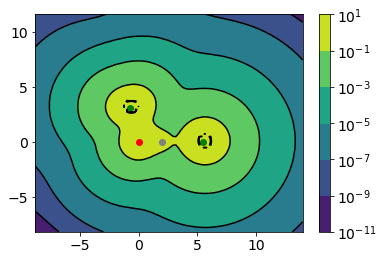

In [17]:
fig, ax = plt.subplots()
CS = ax.contourf(clhocl_0.cdsX,
                 clhocl_0.cdsY,
                 (clhocl_0.density[:,:,33] + clhocl_0.density[:,:,34]).T,
                 norm=LogNorm())
C = ax.contour(clhocl_0.cdsX,
               clhocl_0.cdsY,
               (clhocl_0.density[:,:,33] + clhocl_0.density[:,:,34]).T,
               norm=LogNorm(),
               colors='k')
fig.colorbar(CS)
ax.scatter(clhocl_0.atmAr[:,0][0], clhocl_0.atmAr[:,1][0], color='red')
ax.scatter(clhocl_0.atmAr[:,0][1], clhocl_0.atmAr[:,1][1], color='green')
ax.scatter(clhocl_0.atmAr[:,0][2], clhocl_0.atmAr[:,1][2], color='green')
ax.scatter(clhocl_0.atmAr[:,0][3], clhocl_0.atmAr[:,1][3], color='gray')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.savefig('temp/clhocl_0.png')
plt.show()

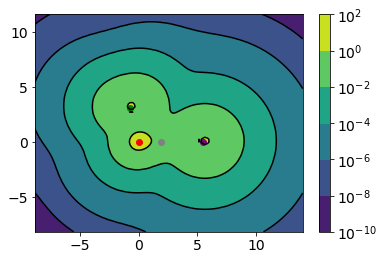

In [18]:
fig, ax = plt.subplots()
CS = ax.contourf(clhocl_15.cdsX,
                 clhocl_15.cdsY,
                 (clhocl_15.density[:,:,33] + clhocl_15.density[:,:,34]).T,
                 norm=LogNorm())
C = ax.contour(clhocl_15.cdsX,
               clhocl_15.cdsY,
               (clhocl_15.density[:,:,33] + clhocl_15.density[:,:,34]).T,
               norm=LogNorm(),
               colors='k')
fig.colorbar(CS)
ax.scatter(clhocl_15.atmAr[:,0][0], clhocl_15.atmAr[:,1][0], color='red')
ax.scatter(clhocl_15.atmAr[:,0][1], clhocl_15.atmAr[:,1][1], color='purple')
ax.scatter(clhocl_15.atmAr[:,0][2], clhocl_15.atmAr[:,1][2], color='green')
ax.scatter(clhocl_15.atmAr[:,0][3], clhocl_15.atmAr[:,1][3], color='gray')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.savefig('temp/clhocl_15.png')
plt.show()

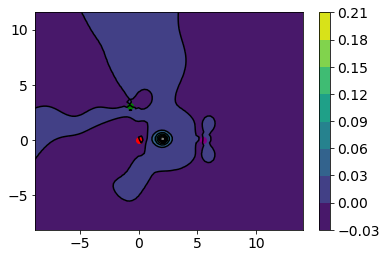

In [39]:
fig, ax = plt.subplots()
CS = ax.contourf(clhocl_15.cdsX,
                 clhocl_15.cdsY,
                 (clhocl_0.density-clhocl_15.density)[:,:,33].T + (clhocl_0.density-clhocl_15.density)[:,:,34].T)
C = ax.contour(clhocl_15.cdsX,
               clhocl_15.cdsY,
               (clhocl_0.density-clhocl_15.density)[:,:,33].T + (clhocl_0.density-clhocl_15.density)[:,:,34].T,
               colors='k')
fig.colorbar(CS)
ax.scatter(clhocl_15.atmAr[:,0][0], clhocl_15.atmAr[:,1][0], color='red')
ax.scatter(clhocl_15.atmAr[:,0][1], clhocl_15.atmAr[:,1][1], color='purple')
ax.scatter(clhocl_15.atmAr[:,0][2], clhocl_15.atmAr[:,1][2], color='green')
ax.scatter(clhocl_15.atmAr[:,0][3], clhocl_15.atmAr[:,1][3], color='gray')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.savefig('temp/clhocl_diff.png')
plt.show()

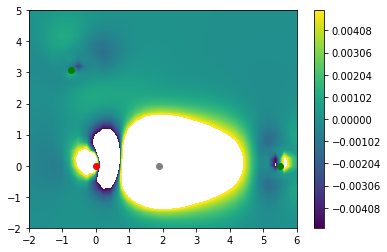

In [71]:
%matplotlib inline
vmin=-0.005
vmax=0.005
levels=500
level_boundaries = np.linspace(vmin, vmax, levels + 1)

fig, ax = plt.subplots()
CS = ax.contourf(clhocl_15.cdsX,
                 clhocl_15.cdsY,
                 zSlice(clhocl_0.density-clhocl_15.density, [32,33,34]),
                 level_boundaries,
                 vmin=vmin, vmax=vmax)
"""C = ax.contour(clhocl_15.cdsX,
               clhocl_15.cdsY,
               zSlice(clhocl_0.density-clhocl_15.density, [32,33,34]),
               colors='k')"""
fig.colorbar(CS)
ax.scatter(clhocl_15.atmAr[:,0][0], clhocl_15.atmAr[:,1][0], color='red')
ax.scatter(clhocl_15.atmAr[:,0][1], clhocl_15.atmAr[:,1][1], color='green')
ax.scatter(clhocl_15.atmAr[:,0][2], clhocl_15.atmAr[:,1][2], color='green')
ax.scatter(clhocl_15.atmAr[:,0][3], clhocl_15.atmAr[:,1][3], color='gray')
ax.set_xlim(-2,6)
ax.set_ylim(-2,5)
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.savefig('temp/clhocl_diff.png')
plt.show()

In [5]:
def zSlice(cube, zInds):
    s = np.zeros(cube[:,:,0].T.shape)
    for i in zInds:
        s = s + cube[:,:,i].T
    return s

In [40]:
def proj(cube, axis):
    print(cube.shape)
    s = np.sum(cube, axis=axis)
    return s

(94, 81, 68)


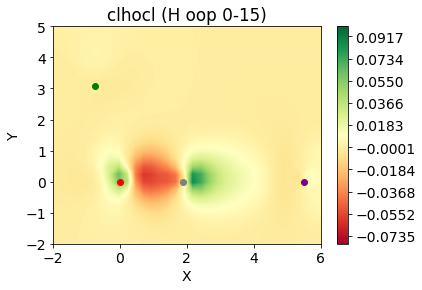

In [41]:
vmin=-0.08
vmax=0.1
levels=500
level_boundaries = np.linspace(vmin, vmax, levels + 1)

fig, ax = plt.subplots()
CS = ax.contourf(clhocl_15.cdsX,
                 clhocl_15.cdsY,
                 proj(clhocl_0.density - clhocl_15.density, axis=2).T,
                level_boundaries,
                 vmin=vmin, vmax=vmax,
                cmap=cm.get_cmap('RdYlGn'))
"""C = ax.contour(clhocl_15.cdsX,
               clhocl_15.cdsY,
               (clhocl_0.density-clhocl_15.density)[:,:,33].T + (clhocl_0.density-clhocl_15.density)[:,:,34].T,
               colors='k')"""
fig.colorbar(CS)
ax.scatter(clhocl_15.atmAr[:,0][0], clhocl_15.atmAr[:,1][0], color='red')
ax.scatter(clhocl_15.atmAr[:,0][1], clhocl_15.atmAr[:,1][1], color='purple')
ax.scatter(clhocl_15.atmAr[:,0][2], clhocl_15.atmAr[:,1][2], color='green')
ax.scatter(clhocl_15.atmAr[:,0][3], clhocl_15.atmAr[:,1][3], color='gray')
ax.set_xlim(-2,6)
ax.set_ylim(-2,5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.title("clhocl (H oop 0-15) ED xy-proj")
plt.savefig('temp/clhocl_Hoop_0-15_xyProj.png')
plt.show()

(94, 81, 68)


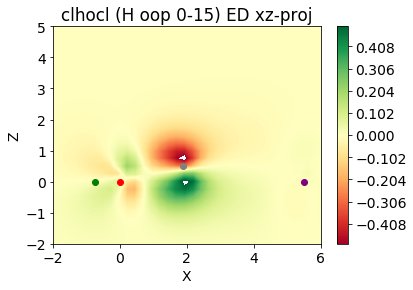

In [45]:
vmin=-0.5
vmax=0.5
levels=500
level_boundaries = np.linspace(vmin, vmax, levels + 1)

fig, ax = plt.subplots()
CS = ax.contourf(clhocl_15.cdsX,
                 clhocl_15.cdsZ,
                 proj(clhocl_0.density - clhocl_15.density, axis=1).T,
                level_boundaries,
                 vmin=vmin, vmax=vmax,
                cmap=cm.get_cmap('RdYlGn'))
"""C = ax.contour(clhocl_15.cdsX,
               clhocl_15.cdsY,
               (clhocl_0.density-clhocl_15.density)[:,:,33].T + (clhocl_0.density-clhocl_15.density)[:,:,34].T,
               colors='k')"""
fig.colorbar(CS)
ax.scatter(clhocl_15.atmAr[:,0][0], clhocl_15.atmAr[:,2][0], color='red')
ax.scatter(clhocl_15.atmAr[:,0][1], clhocl_15.atmAr[:,2][1], color='purple')
ax.scatter(clhocl_15.atmAr[:,0][2], clhocl_15.atmAr[:,2][2], color='green')
ax.scatter(clhocl_15.atmAr[:,0][3], clhocl_15.atmAr[:,2][3], color='gray')
ax.set_xlim(-2,6)
ax.set_ylim(-2,5)
ax.set_xlabel("X")
ax.set_ylabel("Z")
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.title("clhocl (H oop 0-15) ED xz-proj")
plt.savefig('temp/clhocl_Hoop_0-15_xzProj.png')
plt.show()

In [54]:
clhocl_0.cdsZ[33]

0.008263223880597081

In [76]:
zSlice(clhocl_0.density-clhocl_15.density, [32,33,34]).T[:,40]

array([ 1.83270e-08,  2.57560e-08,  3.53200e-08,  4.73700e-08,
        6.23000e-08,  8.05200e-08,  1.02460e-07,  1.28530e-07,
        1.59100e-07,  1.94100e-07,  2.34400e-07,  2.81700e-07,
        3.44300e-07,  4.41000e-07,  6.12000e-07,  9.35000e-07,
        1.52200e-06,  2.53000e-06,  4.11100e-06,  6.39000e-06,
        9.31000e-06,  1.25200e-05,  1.52800e-05,  1.61400e-05,
        1.29000e-05,  2.60000e-06, -1.86000e-05, -5.32000e-05,
       -1.00600e-04, -1.48200e-04, -1.63100e-04, -9.20000e-05,
        1.02000e-04,  3.77000e-04,  5.78000e-04,  5.38000e-04,
        2.35000e-04, -9.60000e-05, -1.18000e-04,  3.53000e-04,
        1.23410e-03,  2.26580e-03,  3.16340e-03,  3.73570e-03,
        3.92610e-03,  3.79870e-03,  3.47890e-03,  3.09040e-03,
        2.71360e-03,  2.37800e-03,  2.07270e-03,  1.76520e-03,
        1.42100e-03,  1.02430e-03,  5.91000e-04,  1.76000e-04,
       -1.34800e-04, -2.59000e-04, -1.78000e-04,  3.10000e-05,
        2.23000e-04,  2.88000e-04,  2.16900e-04,  6.520

In [75]:
clhocl_0.density[:,

(94, 81, 68)

(-0.005, 0.001)

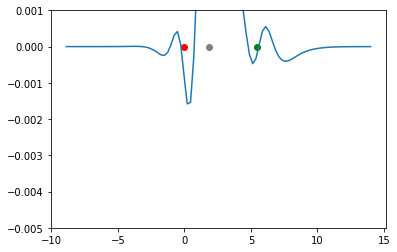

In [11]:
%matplotlib inline
fig = plt.figure()
ax = plt.axes()
ax.plot(clhocl_0.cdsX, zSlice(clhocl_0.density-clhocl_15.density, [32,33,34]).T[:,39])
ax.scatter(clhocl_15.atmAr[:,0][0], clhocl_15.atmAr[:,1][0], color='red')
ax.scatter(clhocl_15.atmAr[:,0][1], clhocl_15.atmAr[:,1][1], color='green')
#ax.scatter(clhocl_15.atmAr[:,0][2], clhocl_15.atmAr[:,1][2], color='green')
ax.scatter(clhocl_15.atmAr[:,0][3], clhocl_15.atmAr[:,1][3], color='gray')
ax.set_ylim(-.005, 0.001)


In [ ]:
dist(clhocl_0.atmAr[0], clhocl_0.atmAr[0])


In [47]:
def dist(a1, a2):
    return np.sqrt(np.power(a1[0]-a2[0], 2)+
                  np.power(a1[0]-a2[0], 2)+
                  np.power(a1[0]-a2[0], 2))